# Analysis for the Pharo kernel phase paper as submitted by Pope et al., 2015. 

### This uses a public kernel phase distribution of 'pysco' (PYthon Self-Calibrating Observables), available at https://github.com/benjaminpope/pysco.  The original pysco code as developed by Martinache, Pope and Ireland is available at https://code.google.com/p/pysco/ .

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysco
# import whisky as pysco
from pysco.diffract_tools import *
import matplotlib as mpl

import fitsio
import triangle
from time import time
from astroML.plotting import setup_text_plots

setup_text_plots(usetex=True)
from time import time as clock
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Now define your data directory, bands - we have Ks and ch4, though the ch4 are provided basically only for illustrative purposes as they're horribly saturated and have been discarded from the paper as submitted.

In [2]:
ddir = "/home/ben/Research/pharo/data/" # data directory

bandn = 'Ks' 
# bandn = 'ch4' # this gives vaguely right astrometry at its best fit but a remarkably poor fit overall! try if you like

num = 0 #0 for alpha Oph, 1 for sim with kp params

tnames = ['alpOph','epsOph','epsHer']

no_kp = False
bispec = False

In [3]:
if bandn == 'ch4':
    fnames = ['cubeF_1856.fits','cubeF_2381.fits']
    # myf1 = open('alpOph_ch4_lin.pick','r')
    # myf2 = open('epsOph_ch4_lin.pick','r')
    pupil = 'stdcrossmodel'
elif bandn == 'Ks':
    fnames = ['cubeF_2056.fits','cubeF_2881.fits']
    # myf1 = open('alpOph_Ks_lin.pick','r')
    # myf2 = open('epsHer_Ks_lin.pick','r')
    pupil = 'medcrossmeasmodel'
    if bispec:
        pupil = 'medcrossmeas_2model'
else: print 'Data directory failure'
    
if num == 1:
    print 'Doing simulated observations'
    fnames = ['binary_129_84_34.fits', 'calibsim.fits'] # ffa
    pupil = 'medcrossmeasmodel'
else:
    pass
    
if num == 2:
    print 'Doing simulated observations'
    fnames = ['binary_130_84_29.fits', 'calibsim.fits'] # ffa
    pupil = 'medcrossmeasmodel'
else:
    pass

print 'Using',pupil,'pupil model.'

Using medcrossmeasmodel pupil model.


After the "import pysco" command, the documentation for the code is
available typing "help(pysco)".

In [4]:
# -------------------
# 1. load the dataset
# -------------------

#load data and calibrators - each of these may take several minutes 

a = pysco.kpo('./kerphi/'+pupil+'.pick')

a.name = 'Palomar - ' + tnames[0]
if no_kp:
    a.kpi.KerPhi = np.eye(a.kpi.nbuv)  # for speckle!
    a.kpi.nkphi = a.kpi.nbuv  # for speckle!

a.extract_kpd(ddir + fnames[0],sg_ld = 7,re_center=True,D=2.3918*2.,unwrap_kp=False,
              adjust_sampling=False,bsp=bispec)

print a.kpd.shape
print a.kpe.shape

if bispec:
    print a.bsp.shape

No bispec
File ./kerphi/medcrossmeasmodel.pick contains kpi information only
Bsp data was not loaded
Vis2 data was not loaded
1 frames will be open
extracting kp from img 100/100 no average
(100, 2692)
(2692,)


In [5]:
b = pysco.kpo('./kerphi/'+pupil+'.pick')
b.name = 'Palomar - ' + tnames[1]
if no_kp:
    b.kpi.KerPhi = np.eye(b.kpi.nbuv)  # for speckle!
    b.kpi.nkphi = b.kpi.nbuv  # for speckle!

b.extract_kpd(ddir + fnames[1],sg_ld = 7.0,re_center=True,D=2.3918*2.,unwrap_kp=False,
              adjust_sampling=False,bsp=bispec)


No bispec
File ./kerphi/medcrossmeasmodel.pick contains kpi information only
Bsp data was not loaded
Vis2 data was not loaded
1 frames will be open
extracting kp from img 100/100 no average


In [6]:
# some of the recentering seems to fail - only sometimes - on Palomar data and I can't work out why, so here are 
# some quick and easy tricks to get rid of bad kernel phases. 
# I have commented out lines that do this. Don't need to run this if it all looks ok! 

# newkpds = np.zeros(a.kpd.shape[1])
# newkpes = np.zeros(a.kpd.shape[1])
# for j in range(a.kpd.shape[1]):
# 	newsignal = pysco.clip_signal(a.kpd[:,j],threshold=2.0)
# 	newkpds[j],newkpes[j] = np.mean(newsignal),np.std(newsignal)/np.sqrt(np.size(newsignal))

# a.kpd,a.kpe = newkpds,newkpes

a.kpe = np.std(a.kpd,axis=0)/np.sqrt(a.kpd.shape[0])

# b.kpe = np.std(a.kpd,axis=0)
# b.kpd = np.mean(a.kpd,axis=0)

# newkpds = np.zeros(b.kpd.shape[1])
# newkpes = np.zeros(b.kpd.shape[1])
# for j in range(b.kpd.shape[1]):
# 	newsignal = pysco.clip_signal(b.kpd[:,j],threshold=2.0)
# 	newkpds[j],newkpes[j] = np.mean(newsignal),np.std(newsignal)/np.sqrt(np.size(newsignal))

# b.kpd,b.kpe = newkpds,newkpes

b.kpe = np.std(b.kpd,axis=0)/np.sqrt(b.kpd.shape[0])

# if it takes a lot of iterations this might be a bad sign and it will warn you
# - you might want to turn off clipping! instead a.kpd = np.mean(a.kpd), a.kpe = np.std(a.kpd)/np.sqrt(nframes)

if num == 0:
    a.kpd = np.mean(a.kpd,axis=0)
    a.nsets = 1
    a.hdr = a.hdr[0]

    b.kpd = np.mean(b.kpd,axis=0)
    b.nsets = 1
    b.hdr = b.hdr[0]

In [7]:
if bispec:
    print 'Doing Bispectrum!'
#     a.bspe = np.std(a.bsp,axis=0)/np.sqrt(a.bsp.shape[0])

    # b.kpe = np.std(a.kpd,axis=0)
    # b.kpd = np.mean(a.kpd,axis=0)

    # newkpds = np.zeros(b.kpd.shape[1])
    # newkpes = np.zeros(b.kpd.shape[1])
    # for j in range(b.kpd.shape[1]):
    # 	newsignal = pysco.clip_signal(b.kpd[:,j],threshold=2.0)
    # 	newkpds[j],newkpes[j] = np.mean(newsignal),np.std(newsignal)/np.sqrt(np.size(newsignal))

    # b.kpd,b.kpe = newkpds,newkpes

#     b.bspe = np.std(b.bsp,axis=0)/np.sqrt(b.bsp.shape[0])

    # if it takes a lot of iterations this might be a bad sign and it will warn you
    # - you might want to turn off clipping! instead a.kpd = np.mean(a.kpd), a.kpe = np.std(a.kpd)/np.sqrt(nframes)

    if num == 0:
        a.bsp = np.mean(a.bsp,axis=0)
        a.nsets = 1

        b.bsp = np.mean(b.bsp,axis=0)
        b.nsets = 1
    else:
        a.bspe = errors
        a.nsets = 1

In [8]:
#calibrate - this is a crude way to do things, but as we discuss in the paper, the systematics are bad enough 
# that it is unlikely that a clever Bayesian way of doing things would be much better
# if num == 0:
if no_kp:
    addederror = 8.5
else:
    addederror = 1.37

a.kpd -= b.kpd #subtract systematic
a.kpe = np.sqrt(a.kpe**2. + b.kpe**2.+ addederror**2.) #add statistical and measurement in quadrature
if bispec:
    print 'Calibrating Bispectrum'
    bsp_addederror = 7.6
    a.bsp -= b.bsp
    a.bspe = np.sqrt(a.bspe**2. + b.bspe**2. * bsp_addederror**2)
    

if num != 0:
    a.kpe = error_kp*np.ones_like(a.kpe)
# else:
#     addederror = 1.05
#     print 'no systematic subtraction'
#     a.kpe = np.sqrt(a.kpe**2. + addederror**2.) #add statistical and measurement in quadrature
#     print addederror


# you may want to add an error term in quadrature - see the note later! 1.0 should do the job 

In the following two cells we have two different ways of fitting a model to these data - one uses MultiNest and one uses emcee.

MultiNest is available at http://ccpforge.cse.rl.ac.uk/gf/project/multinest/, and is accessed through Johannes Buchner's PyMultiNest Python wrapper available at http://johannesbuchner.github.io/PyMultiNest/ . These can be difficult to install, especially on some operating systems, and we do not use these results in the final paper, as we explore the posterior pdf more fully with emcee.

emcee, the 'MCMC Hammer', is available from http://dan.iel.fm/emcee/current/ and is the main sampler used in the paper as submitted. We recommend initializing this and using its default values, as this will give the same results as we report in the paper. 

In [9]:
a.hdr

{'DEC': 12.5574722,
 'RA': 263.73376,
 'coadds': 1,
 'filter': 2.145e-06,
 'filtname': 'K_short',
 'grism': 'ND 0.1%',
 'odate': '2012-06-26',
 'orient': -219.97,
 'otime': '08:19:43',
 'pscale': 25.2,
 'pupil': 'Med Cross',
 'tel': 'Hale 200 inch',
 'tint': 1416}

In [10]:
# # MultiNest Option 
paramlimits = [100.,150.,0.,360.,10.,40.]

results = pysco.nest(a,paramlimits=paramlimits)

params = [results[0]['median'],results[1]['median'],results[2]['median']]

print 'Sep %.3f mas  Position angle %.3f deg  Contrast %.3f' % (params[0], params[1], params[2]) 

Modelling kernel phases with nested sampling
  analysing data from chains/1-.txt
Time elapsed = 7.17351093292 mins

------------------------------ ANALYSIS ------------------------------
Global Evidence:
	5.954467817656041e+02 +- 9.907230013558575e-02
Separation: 129.169 pm 1.20
Position angle: 83.836 pm 0.32
Contrast at 2.145 um: 34.263 pm 1.057
Sep 129.169 mas  Position angle 83.836 deg  Contrast 34.263


In [11]:
flatchain = pysco.hammer(a,ivar = [131.23, 82.84, 27.59], burnin=100, nsteps=1000, paramlimits=[40,250,0,360,5,50.]) 
# Parameters as determined by aperture masking: [131.23, 82.84, 27.59]

seps = flatchain[:,0]
ths = flatchain[:,1]
cons = flatchain[:,2]

sep = np.mean(seps)

th = np.mean(ths) # remember on Palomar the position angle goes the other way - so check this is not 360 - your answer!

con = np.mean(cons)

print 'Sep %.3f mas  Position angle %.2f deg  Contrast %.3f' % (sep, th, con)  
params = [sep,th,con]


Running emcee now!
Burnt in! Took 124.093 seconds
Time elapsed = 1383.688 s
Separation 129.161 pm 1.207 mas
Position angle 83.795 pm 0.321 deg
Contrast at 2.145 um 34.267 pm 1.090
Sep 129.161 mas  Position angle 83.79 deg  Contrast 34.267


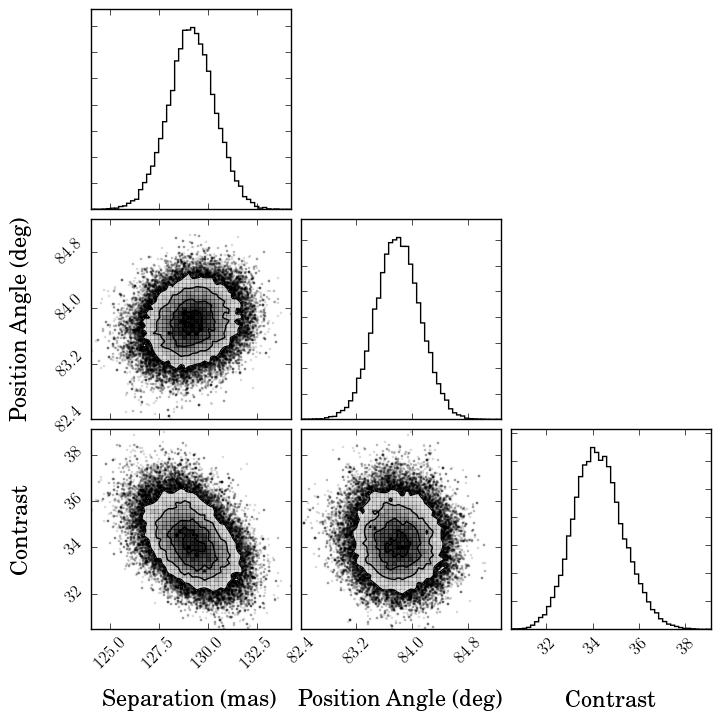

In [12]:
# now plot your results! requires emcee output 
# if you have outliers you may have to fiddle with the extents 
% matplotlib inline

import matplotlib as mpl

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=44                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

import matplotlib.pyplot as plt


if bispec:
    method = 'Bispectrum'
else:
    method = 'Kernel Phase'
fig = triangle.corner(flatchain,labels=[r"Separation (mas)", r"Position Angle (deg)", r"Contrast"],
                      title_kwargs={"fontsize": 'large'},label_kwargs={"fontsize":32})

plt.show()
# plt.savefig('./posterior.png')

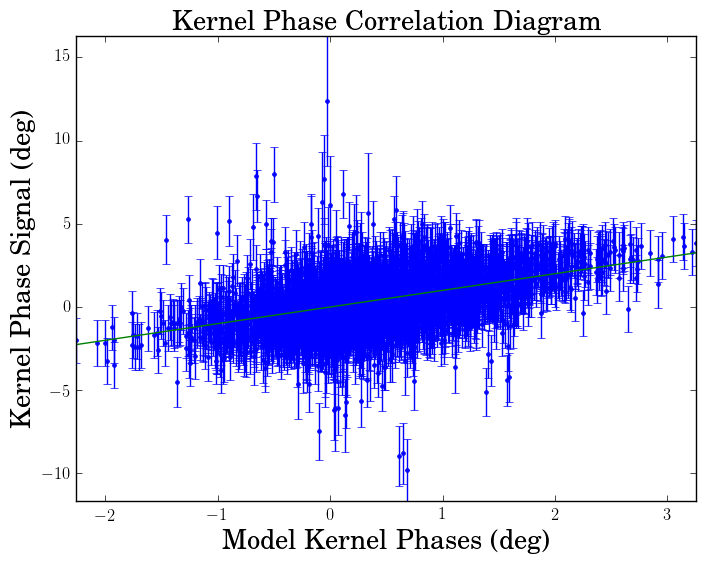

In [13]:
# params = [sep,th,con]
# params = [131.23,82.6, 19.7]
# params = [sep,83.5,con]
# params = [126.625, 85.045, 26.043]

d = pysco.binary_model(params,a.kpi,a.hdr,bispec=bispec)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']= 16               #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.clf()
# if bispec:
# #     plt.errorbar(d[np.abs(a.bsp)<50],a.bsp[np.abs(a.bsp)<50],yerr=a.bspe[np.abs(a.bsp)<50],fmt='b.')
#     plt.errorbar(d,a.bsp,yerr=a.bspe,fmt='b.')
#     mm = np.round(np.max(np.abs(a.bsp)))
# #     mm = 42
# #     mm = 10
#     plt.axis([-mm,mm,-mm,mm],fontsize='large')
# else:
if bispec:
    mm = np.round(np.max(np.abs(a.bsp)))
    plt.errorbar(d,a.bsp,yerr=a.bspe,fmt='b.')
    plt.axis('tight',fontsize='large')
    plt.plot([-mm,mm],[-mm,mm], 'g')
else:
    mm = np.round(np.max(np.abs(a.kpd)))
    plt.errorbar(d,a.kpd,yerr=a.kpe,fmt='b.')
    plt.axis('tight',fontsize='large')
    plt.plot([-mm,mm],[-mm,mm], 'g')


if bispec:
    plt.xlabel('Model Bispectral Phases (deg)',fontsize='large')
    plt.ylabel('Bispectral Phase Signal (deg)', fontsize='large')
    plt.title('Bispectrum Correlation Diagram',
          fontsize='large') 
elif no_kp:
    plt.xlabel('Model Phases',fontsize='large')
    plt.ylabel('Raw Phase Signal', fontsize='large')
    plt.title('Raw Phase Correlation Diagram',
          fontsize='large')
else:
    plt.xlabel('Model Kernel Phases (deg)',fontsize='large')
    plt.ylabel('Kernel Phase Signal (deg)', fontsize='large')
    plt.title('Kernel Phase Correlation Diagram',
		  fontsize='large')
plt.draw()
plt.show()
plt.savefig('./correlation_Ks.png')


There is a problem in the above! As you'll notice if you don't include an error term added in quadrature, it's got enormously more scatter than the error bars suggest. This is because the error bars are probably way too small - they are derived from scatter in the observations, whereas we know that due to saturation, a ghost (!) and poor AO performance they are likely to suffer from a systematic offset as well.

As a result, we will recalculate all of the above, adding a second error term in quadrature to get a chi2 of 1 and redoing the MCMC.

To help you out, as we note above, we found that the best error to do this is 1 degree, but feel free to play with this.

In [14]:
print params

[129.16068878011711, 83.794655007171258, 34.266985703860712]


In [15]:
if bispec:
    chi2 = np.sum(((a.bsp -d)/a.bspe)**2.)
    print a.bsp.max()
else:
    chi2 = np.sum(((a.kpd -d)/a.kpe)**2.)

print 'Reduced chi2 = %03f'%(chi2/(a.kpi.nkphi-4.))

Reduced chi2 = 1.029505


## Thank you for taking the time to read this! I hope this was enlightening and maybe you can even use some of this in your own research.  Cheers,  Ben

Other relevant code follows below the line...


#---------------------------------------------------------------------------

## Now we're going to use Alex and Mike's MEM code to try and use the kernel phase information to deconvolve the images differently. This at present uses a high-contrast approximation (small-phase, ie phase ~ imaginary component) to simplify the matrices (DFT -> sine, so no complex operations).

In [10]:
'''----------------------------------------------------
Now to make deconvolved images! 

In mk_kp2implane run kerphimobj(kpi, keywords), 
giving it a kpi object & some necessary keywords outlined
in the code, importantly kerph and kerpherr --- a set of 
kernel phases (radians) and errors. 
----------------------------------------------------'''

from imaging import *
# bispec = True
fov = 80
tic1= time()
kpimobj = kerphimobj(a,fov=fov,bsp=bispec)
if bispec:
    kpimobj.name = 'test_bispec'
else:
    kpimobj.name = 'test'
kpimobj.kp2pm,kpimobj.sym2im = kpimobj.kerph2im(theta=a.hdr['orient'])
toc1=time()
kpimobj.write()
print toc1-tic1, 'seconds elapsed'

Failed to load bispectrum data
445.810727119 seconds elapsed


In [43]:
'''------------------------------
Now run it!
------------------------------'''

#	imsize -- the size of the image in pixels, needs to match input
#			  file 'pixel matrix' size
#	alpha  -- A starting value for the MEM functional multiplier (default=1.0)
#	gain   -- The servo gain for adjusting alpha to achieve chi^2=1
#	niter  -- number of iterations
#	prior  -- as mentioned at the start of this script, the prior
#			  is used to contrain the flux

from imaging import *
%matplotlib inline

'''defaults'''
if no_kp:
    imsize = 40
    alpha = 0.5
    gain = 0.0001
    prior = np.ones(imsize**2)/imsize**2.0
elif bispec:
    print 'Using bispec configuration'
    imsize = 80
    alpha = 1.5
    gain = 0.004
    prior = np.ones(imsize**2)/imsize**2.0   
else:
    imsize = 80
    alpha = 35
    gain = 0.0042
    prior = np.ones(imsize**2)/imsize**2.0

# xx,yy= np.meshgrid(np.arange(imsize)-imsize/2.,np.arange(imsize)-imsize/2.)
# rr = np.sqrt(xx**2. + yy**2.)
# prior1= np.exp(-(rr/(imsize/2.))**2)
# prior = np.ravel(prior1/np.sum(prior1))

niter = 400
if bispec:
    fname_im = 'kerphim_test_bispec.fits'
else:
    fname_im = 'kerphim_test.fits'
# trial.read_data(fname_im)

tic = time()
trial = MemImage(fname_im, niter=niter,imsize=imsize,alpha=alpha,gain=gain,prior=prior)
im = trial.mem_image()
toc = time()
print toc-tic, 'seconds elapsed'


#now save as a .fits file
try:
    if bispec:
        f = fitsio.FITS('./mem_image_bispec.fits','rw')
        f.write(im)
        f.close()
        print 'Written as ./mem_image_bispec.fits' 
    else:
        f = fitsio.FITS('./mem_image_kp.fits','rw')
        f.write(im)
        f.close()
        print 'Written as ./mem_image_kp.fits'
except:
    print 'Failed to write'


Initialized: image size 80
Done: 10 of 400 iterations. Chi^2: 2171.9472806 alpha: 35.039734832 chi2diff: 0.18105542343
Done: 20 of 400 iterations. Chi^2: 2273.88905918 alpha: 35.2809045359 chi2diff: 0.150446131525
Done: 30 of 400 iterations. Chi^2: 2246.55326356 alpha: 35.5231083789 chi2diff: 0.165494836876
Done: 40 of 400 iterations. Chi^2: 2256.77303778 alpha: 35.7675854909 chi2diff: 0.161655690957
Done: 50 of 400 iterations. Chi^2: 2261.58231692 alpha: 36.0100336626 chi2diff: 0.159870766986
Done: 60 of 400 iterations. Chi^2: 2266.59620053 alpha: 36.2514018358 chi2diff: 0.158375917146
Done: 70 of 400 iterations. Chi^2: 2270.77295489 alpha: 36.4916794314 chi2diff: 0.156548225663
Done: 80 of 400 iterations. Chi^2: 2276.74124739 alpha: 36.7306059809 chi2diff: 0.154601253517
Done: 90 of 400 iterations. Chi^2: 2280.84387437 alpha: 36.9684386812 chi2diff: 0.15295351747
Done: 100 of 400 iterations. Chi^2: 2284.82775047 alpha: 37.2052758347 chi2diff: 0.151259688024
Done: 110 of 400 iteration

Total contrast (mags): 1.07966025477


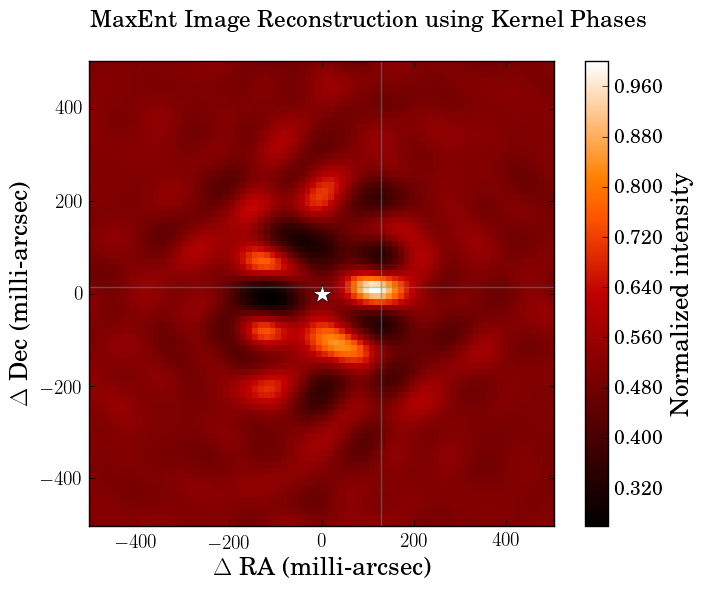

In [44]:
'''--------------------------------
the rest is a plot
--------------------------------'''


mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']= 14             #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

bestfit = np.array([129.2*np.sin(np.pi/180.*83.8),129.2*np.cos(np.pi/180.*83.8)])
plt.clf()
plt.imshow(im[::-1,:].T/im.max(), interpolation='nearest',cmap=plt.get_cmap('gist_heat'),extent=trial.extent,origin='lower')
cbar = plt.colorbar(label='Normalized intensity',format='%.3f')
plt.plot(0,0,'w*', ms=15)
plt.axis(np.array(trial.extent)*np.array([-1,-1,1,1]))
plt.axhline(bestfit[1],color='c',alpha=0.5)
plt.axvline(bestfit[0],color='c',alpha=0.5)
# plt.plot(bestfit[0],bestfit[1],'cs',alpha=0.8)
plt.xlabel(r'$\Delta$ RA (milli-arcsec)')
plt.ylabel(r'$\Delta$ Dec (milli-arcsec)')
if no_kp:
    plt.title('MaxEnt Image Reconstruction using Fourier Phases',fontsize='large',y=1.06,x=0.6)
elif bispec:
    plt.title('MaxEnt Image Reconstruction using Bispectral Phases',fontsize='large',y=1.06,x=0.6)
else:
    plt.title('MaxEnt Image Reconstruction using Kernel Phases',fontsize='large',y=1.06,x=0.6)
print "Total contrast (mags): " + str(-2.5*np.log10(np.sum(trial.pm)))
plt.show()

In [33]:
# z = pysco.kpi('./kerphi/medcrossmeas.txt') # in case you need to make it - edit this!

## The following code produces a binary simulation to benchmark against.

In [6]:
####################
## Simulate images!
####################

sep, theta, contrast = 129.6, 83.5, 28.7

image, coords = make_binary(sep,theta,contrast,spaxel=25.2,wavel=2.145e-6,sz=4096*2)

imageToFits(image,filename=ddir+'/binary_%.0f_%.0f_%.0f.fits' % (sep,theta,contrast),path='')

print 'Saved mock binary to %s/binary_%.0f_%.0f_%.0f.fits' % (ddir,sep,theta,contrast)

image2, coords2 = diffract(spaxel=25.2,wavel=2.145e-6,sz=4096*2)

imageToFits(image2,filename=ddir+'/calibsim.fits',path='')

print 'Saved mock calibrator to %s/calibsim.fits' % (ddir)

Lambda/D = 95.2205038068 mas
Native plate scale =  8.40720949711
Spaxel scale - done!
x 0.582187956521 ,y 5.10979811491
Saved mock binary to /home/ben/Research/pharo/data//binary_130_84_29.fits
Lambda/D = 95.2205038068 mas
Native plate scale =  8.40720949711
Spaxel scale - done!
Saved mock calibrator to /home/ben/Research/pharo/data//calibsim.fits


In [5]:
np.sqrt(0.527831518265**2 + 5.10772002123**2)*25.2

129.40000000003431

### The following cell writes out a single cleaned, stacked image - I put this in there so that collaborators could look at the data exactly as they appear to the kernel phase code.

In [ ]:
'''------------------------------------------------
Write out a cleaned stacked cube
------------------------------------------------'''

#read it in - using the pysco routine so as to get the centering correct

cube,hdr = pysco.load_cube(ddir+fnames[0])

#stack centred images
stacked_cube = np.sum(cube,axis = 0)

#now save as a .fits file
try:
    f = fitsio.FITS('./stacked_cube_%s_%s.fits'%(tnames[0],bandn),'rw')
    f.write(stacked_cube,hdr=hdr)
    f.close()
    print 'Written as ./stacked_cube_%s_%s.fits'%(tnames[0],bandn)
except:
    print 'Failed to write'

#do calibrator
calcube,calhdr = pysco.load_cube(ddir+fnames[1])

#stack centred images
stacked_cube_cal = np.sum(calcube,axis = 0)

#now save as a .fits file
try:
    f = fitsio.FITS('./stacked_cube_%s_%s_cal.fits'%(tnames[1],bandn),'rw')
    f.write(stacked_cube_cal,hdr=hdr)
    f.close()
    print 'Written as ./stacked_cube_%s_%s_cal.fits'%(tnames[1],bandn)
except:
    print 'Failed to write'

### In this section, we are just going to make sure that everything worked out ok with the pupil model and plot the image, its Fourier transform, and the relevant sampling points. There should be a circle in the uv plane of nonzero visibility and nontrivial, small phase, and all the baselines (blue) should fall just within this.

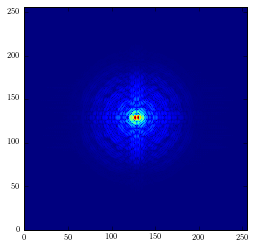

In [7]:
ims = np.array(a.im-b.im)
avgim = ims#np.sum(ims,axis=0)[256-64:256+64,256-64:256+64]
plt.imshow(np.abs(avgim)**0.3)
plt.show()

In [8]:
pupilmap, xx, m2pix = palomarpupil(sz=4096)

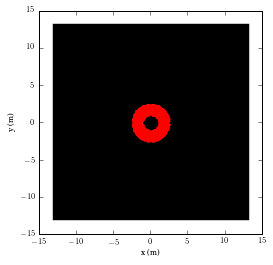

In [9]:
sz = pupilmap.shape[0]/2.
plt.imshow(pupilmap[sz-sz/2:sz+sz/2,sz-sz/2:sz+sz/2],cmap=plt.cm.gray,extent=[xx.min()/2.,xx.max()/2.,xx.min()/2.,xx.max()/2.])
plt.plot(a.kpi.mask[:,0],a.kpi.mask[:,1],'.r')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [10]:
np.sqrt(a.kpi.mask[:,0]**2 + a.kpi.mask[:,1]**2).max()

2.391800000030055

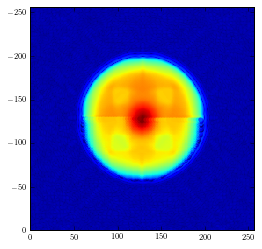

In [11]:
ac_mod = np.abs(a.ac)
avg_vis = ac_mod#np.sum(ac_mod,axis=0)
vis_err = np.ones_like(ac_mod)#np.std(ac_mod,axis=0)

sz, dz = a.im.shape[1], a.im.shape[1]/2
m2pix = pysco.mas2rad(a.hdr['pscale'] * sz / a.hdr['filter'])
uv_samp = a.kpi.uv * m2pix*1.001 + dz # uv sample coordinates in pixels
# uv_samp = pysco.adjust_samp(uv_samp,a.kpi,m2pix,sz)
uv_samp_rev=np.cast['int'](np.round(uv_samp))
uv_samp_rev[:,0]*= -1.0

p
plt.imshow(avg_vis**0.2,extent=[0,sz,0,-sz])
plt.scatter(uv_samp_rev[:,1], uv_samp_rev[:,0],c=a.kpi.RED**0.2,lw=0)
plt.axis([0,sz,0,-sz])
plt.show()

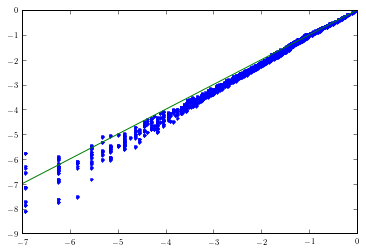

In [12]:
visb = avg_vis[uv_samp_rev[:,1], uv_samp_rev[:,0]]                
visb /= visb.max()
plt.plot(np.log(b.kpi.RED/b.kpi.RED.max()),np.log(visb),'.b')
plt.plot([-7,0],[-7,0],'-g')
plt.show()

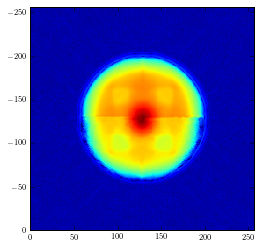

In [13]:
ac_mod = np.abs(a.ac)
# avg_vis = np.sum(ac_mod,axis=0)
avg_vis = ac_mod
# vis_err = np.std(ac_mod,axis=0)

sz, dz = a.im.shape[1], a.im.shape[1]/2
m2pix = pysco.mas2rad(a.hdr['pscale'] * sz / a.hdr['filter'])
uv_samp = a.kpi.uv * m2pix + dz # uv sample coordinates in pixels
uv_samp = pysco.adjust_samp(uv_samp,a.kpi,m2pix,sz)
uv_samp_rev=np.cast['int'](np.round(uv_samp))
uv_samp_rev[:,0]*= -1.0

plt.imshow(avg_vis**0.2,extent=[0,sz,0,-sz])
plt.scatter(uv_samp_rev[:,1], uv_samp_rev[:,0],c=a.kpi.RED**0.2,lw=0)
plt.axis([0,sz,0,-sz])
plt.show()

[0, 256, 0, -256]

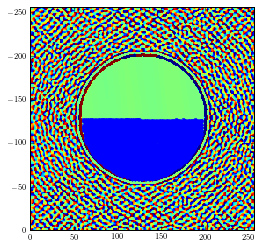

In [14]:
ac_phase = np.angle(a.ac)
avg_phase = ac_phase
# avg_phase = np.sum(ac_phase,axis=0)
sz = b.im.shape[0]

plt.imshow(avg_phase,extent=[0,sz,0,-sz])
plt.plot(uv_samp_rev[:,1], uv_samp_rev[:,0],'.b')
plt.axis([0,sz,0,-sz])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from IPython.kernel.zmq import kernelapp as app


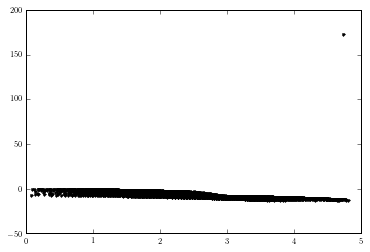

In [42]:
data_cplx=a.ac[uv_samp_rev[:,1], uv_samp_rev[:,0]]    
plt.plot(np.sqrt(a.kpi.uv[:,0]**2+a.kpi.uv[:,1]),np.angle(data_cplx)/dtor,'.k')

In [31]:
visb = avg_vis[uv_samp_rev[:,1], uv_samp_rev[:,0]]                
visb /= visb.max()

In [28]:
plt.plot(np.log(b.kpi.RED/b.kpi.RED.max()),np.log(visb),'.b')
plt.plot([-5,0],[-5,0],'-g')

NameError: name 'visb' is not defined

In [16]:
from scipy.optimize import leastsq,fmin,curve_fit,brute
from mk_test_pupil import *

def compare_pupil_model(kpo,uv,RED,scale=1.0):
    
    uv *= scale

    ### First generate your pupil mode
    ac_mod = (np.abs(kpo.acs)/np.max(np.abs(kpo.acs))).astype(np.float64)
    avg_vis2 = np.mean(np.log(ac_mod),axis=0)
    vis_err2 = np.std(np.log(ac_mod),axis=0)

    sz, dz = kpo.ims.shape[1], kpo.ims.shape[1]/2
    m2pix = pysco.mas2rad(kpo.hdr['pscale'] * sz / kpo.hdr['filter'])
    
    uv_samp = uv * m2pix + dz # uv sample coordinates in pixels
#     uv_samp = pysco.adjust_samp(uv_samp,b.kpi,m2pix,sz)
    uv_samp_rev=np.cast['int'](np.round(uv_samp))
    uv_samp_rev[:,0]*= -1.0
    visb2 = avg_vis2[uv_samp_rev[:,1], uv_samp_rev[:,0]]    
    visb2err = vis_err2[uv_samp_rev[:,1], uv_samp_rev[:,0]]
    visb2 -= visb2.max()
    
    return visb2, visb2err, np.log(RED/np.float(RED.max()))

# =========================================================================
# ========================================================================

def fit_mask_residuals(params,kpo,srad=0.33):
    ''' Function to evaluate fit residuals, to be used in a leastsq
    fitting procedure. '''

    mask = make_test_pupil(params[0],params[1],params[2],srad=srad)
    uv, RED = do_uv_red(mask,Ns=3.)
    
    visb, visberr, model = compare_pupil_model(kpo,uv,RED)
#     visberr *= 1000
    visberr = 1.
    err = ((visb-model)/visberr)**2/model.shape[0]
    return np.sum(err).astype(np.float64)

def fit_mask_residuals_mask(uv,RED,kpo,scale=1.0):
    ''' Function to evaluate fit residuals, to be used in a leastsq
    fitting procedure. '''

    visb, visberr, model = compare_pupil_model(kpo,uv,RED,scale=scale)
#     visberr *= 1000
    visberr = 1.
    err = ((visb-model)/visberr)**2/model.shape[0]
    return np.sum(err).astype(np.float64)

# =========================================================================
# =========================================================================

def fit_mask(kpo, p0):
    '''Performs a best binary fit search for the datasets.
    
    -------------------------------------------------------------
    p0 is the initial guess for the parameters 3 parameter vector
    typical example would be : [100.0, 0.0, 5.0].
    
    returns the full solution of the least square fit:
    - soluce[0] : best-fit parameters
    - soluce[1] : covariance matrix
    ------------------------------------------------------------- '''
    
    soluce = leastsq(fit_mask_residuals, 
                     p0, args=((kpo,)),
                     full_output=1)
    #     covar = soluce[1]

#     soluce = fmin(fit_mask_residuals, p0.flatten(), args=(kpo,))
    return soluce

def fit_mask_lm(kpo, p0):
    '''Performs a best binary fit search for the datasets.
    
    -------------------------------------------------------------
    p0 is the initial guess for the parameters 3 parameter vector
    typical example would be : [100.0, 0.0, 5.0].
    
    returns the full solution of the least square fit:
    - soluce[0] : best-fit parameters
    - soluce[1] : covariance matrix
    ------------------------------------------------------------- '''
    
#     soluce = leastsq(fit_mask_residuals, 
#                      p0, args=((kpo,)),
#                      full_output=1)
    
    soluce = curve_fit(fit_mask_residuals, p0.flatten(), args=(kpo,))
    covar = soluce[1]
    return soluce

def fit_mask_brute(kpo):
    '''Performs a best binary fit search for the datasets.
    
    -------------------------------------------------------------
    p0 is the initial guess for the parameters 3 parameter vector
    typical example would be : [100.0, 0.0, 5.0].
    
    returns the full solution of the least square fit:
    - soluce[0] : best-fit parameters
    - soluce[1] : covariance matrix
    ------------------------------------------------------------- '''
    
    soluce = brute(fit_mask_residuals, 
                     ((2.2,2.5),(0.4,0.5),(0,15,0.25)), args=((kpo,)), Ns=5,
                     full_output=1,disp=True)
    #     covar = soluce[1]

#     soluce = fmin(fit_mask_residuals, p0.flatten(), args=(kpo,))
    return soluce

In [17]:
# visb2, visb2err, red = compare_pupil_model(b,5.093/2* 15.4/16.88,1/2.0,0.24)

In [18]:
# plt.errorbar(red,visb2,yerr=visb2err,fmt=None)

In [19]:
# soluce = fit_mask_brute(b)

In [13]:
# # p0 = np.array([2.32322867,0.5,0.21]).astype(np.float64)
# print np.sum(fit_mask_residuals(p0,b)**2.)
# soluce = fit_mask(b,p0)
# print soluce
# print np.sum(fit_mask_residuals(soluce,b)**2.)

In [11]:
from time import time as clock
tic = clock()
# print np.sum(fit_mask_residuals([2.32322867, 0.55, 0.21],b)**2.)
print fit_mask_residuals([2.32322867, 0.55, 0.21],b)
# print np.sum(fit_mask_residuals([2.32322867, 0.49, 0.24],b)**2.)
print clock()-tic

27.0773625938
1.69236683846


In [15]:
# nsamp = 6
# rmaxes, ratios, spiders = np.linspace(2.37,2.39,nsamp), np.linspace(0.59,0.61,nsamp), np.linspace(0.22,0.24,nsamp)
# chi2s = np.zeros((nsamp,nsamp))
# tic = clock()
# for j in range(nsamp):
#     print 'up to',j
#     for k in range(nsamp):
#         chi2s[j,k] = fit_mask_residuals([rmaxes[j],ratios[k],0.2292],b)
# print clock()-tic

In [16]:
# print np.where(chi2s==chi2s.min())
# print chi2s
# print np.min(chi2s)
# print rmaxes[3]
# print ratios[5]

In [17]:
# plt.imshow(chi2s)

42.2679080869


<Container object of 3 artists>

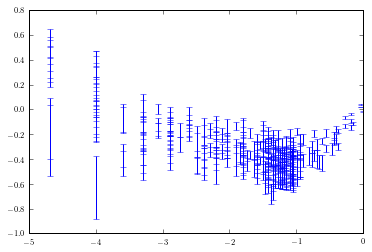

In [21]:
# visb2m, visb2errm, redm = compare_pupil_model(b,2.323, 0.47195, 0.2292,srad=0.11)
# visb2m, visb2errm, redm = compare_pupil_model(b,2.382, 0.61, 0.2292)
visb2m, visb2errm, redm = compare_pupil_model(b,2.323, 0.49195, 0.16,srad=0.33)

print np.sum(((visb2m-redm)/visb2errm)**2)/np.shape(visb2m)[0]

plt.errorbar(redm,visb2m-redm,yerr=visb2errm,fmt=None)

In [ ]:
1.829/2. * 7.6/6.08/2.323

In [ ]:
0.83 *15.4/16.88/4./(2.323-0.49195*2.323)

In [24]:
chi2p = np.zeros(20)
tic = clock()
for j,r in enumerate(np.linspace(2.38,2.405,20)):
    chi2p[j] = fit_mask_residuals([r,1./2.11885, 0.2292],b,srad=0.2)
print clock()-tic

114.761473179


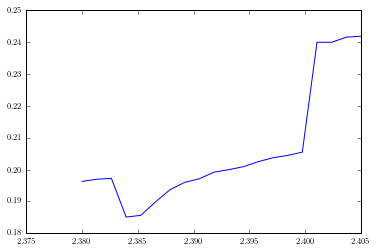

In [25]:
plt.plot(np.linspace(2.38,2.405,20),chi2p)

In [23]:
rs = np.linspace(2.38,2.405,20)
rs[np.argmin(chi2p)]

2.3799999999999999

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:2652: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


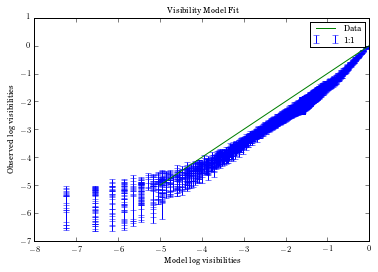

In [20]:
mask = make_test_pupil(2.3918, 1./2.11885, 0.2292,srad=0.1)
uv, RED = do_uv_red(mask,Ns=3.)

visb2m, visb2errm, redm = compare_pupil_model(b,uv,RED)
plt.errorbar(redm,visb2m,yerr=visb2errm,fmt=None)
plt.plot([-5,0],[-5,0],'-g')
plt.legend(['Data','1:1'])
plt.xlabel('Model log visibilities')
plt.ylabel('Observed log visibilities')
plt.title('Visibility Model Fit')

In [27]:
chi2b = np.zeros(100)
tic = clock()
for j,sec in enumerate(np.linspace(0.47,0.52,100)):
    chi2b[j] = fit_mask_residuals([2.35,sec, 0.2292],b)
print clock()-tic

305.864490986


In [28]:
chi2c = np.zeros(100)
tic = clock()
for j,sec in enumerate(np.linspace(0.47,0.5,100)):
    chi2c[j] = fit_mask_residuals([2.2669172932330826,sec, 0.2292],b)
print clock()-tic

301.643508911


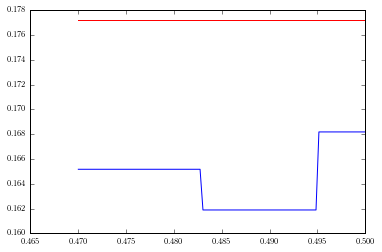

In [29]:
plt.plot(np.linspace(0.47,0.5,100),chi2b,'-b')
plt.plot(np.linspace(0.47,0.5,100),chi2c,'-r')

In [38]:
nchi2 = 20
chi2d = np.zeros(nchi2)
tic = clock()
# mask = make_test_pupil(2.35, 0.49, 0.2292,srad=0.33)
# uv,red = do_uv_red(mask,Ns=3.)

for j,sc in enumerate(np.linspace(0.8,1.1,nchi2)):
    chi2d[j] = fit_mask_residuals_mask(uv,red,b,scale=sc)
print clock()-tic

80.5986142159


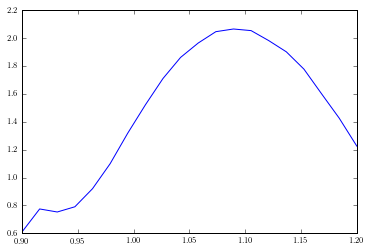

In [39]:
plt.plot(np.linspace(0.9,1.2,nchi2),chi2d)

In [27]:
a.kpd.shape

(1201,)